### Reading file

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
df = pd.read_csv('AirPassengers.csv') #reading the file
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
df.dtypes

Month          object
#Passengers     int64
dtype: object

In [4]:
#Month is not readed as datetitme object, we should add a parser function when reading the file

parser = lambda date: pd.datetime.strptime(date, '%Y-%m') #parser function
df = pd.read_csv('AirPassengers.csv',parse_dates=['Month'], index_col='Month', date_parser=parser)#also month column is set as index
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
df.index #index columns is a datetime index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [6]:
#In this case we have only one column, so we can convert it to pandas series to avoid naming the column all the time
ts = df['#Passengers']
ts.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

### Slicing 

In [7]:
#Selecting an specific date
ts['1950-03-01']

141

In [8]:
#Selecting a range
ts['1949-02-01':'1949-05-01']

Month
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

Important to note: end of the range is included

In [9]:
#Selecting a range from the begining
ts[:'1949-06-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
Name: #Passengers, dtype: int64

In [10]:
#Selecting a range until the end
ts['1960-10-01':]

Month
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: #Passengers, dtype: int64

In [11]:
#Selecting a whole year
ts['1950']

Month
1950-01-01    115
1950-02-01    126
1950-03-01    141
1950-04-01    135
1950-05-01    125
1950-06-01    149
1950-07-01    170
1950-08-01    170
1950-09-01    158
1950-10-01    133
1950-11-01    114
1950-12-01    140
Name: #Passengers, dtype: int64

### Checking stationarity

Time series are stationary if they have the following properties:
* constant mean
* constant variance
* autocovariance is not time dependant

To check stationarity in the series we can apply two methods:
<ol> 
    <li>plotting series to check if mean and variance are constant over time
    <li>Dickey Fuller test statistic, if the value of the statistics is lower than the critical value we can reject the null hypothesis and say that the series is stationary
</ol>

In [12]:
#We will pack the two methods in a function
from statsmodels.tsa.stattools import adfuller

def test_stationarity(time_series):
    #rolling statistics
    roll_mean = time_series.rolling(window=12).mean()
    roll_std = time_series.rolling(window=12).std()
    
    #plotting rolling statistics
    oring = plt.plot(time_series, color='blue', label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling mean')
    std = plt.plot(roll_std, color='black', label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling mean & standard deviation')
    plt.show(block=False)
    
    #Dickey Fuller test
    print('Results of Dickey Fuller Test')
    dftest = adfuller(time_series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


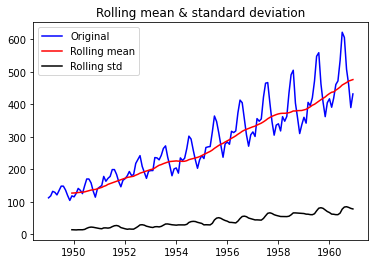

Results of Dickey Fuller Test
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [13]:
test_stationarity(ts)

Test statistic is far more than the critical values so we can not say that the series are stationary.

### Making a time series stationary

Non stationarity in time series is mainly due to two reasons:
<ul>
    <li>Trend
    <li>Seasonality
When happens, we should remove trend and seasonality in the time series to make it stationary.
</ul>

#### Removing trend

Let's see several transformations to remove trend in a series. Not all these methods will work in a specific series.

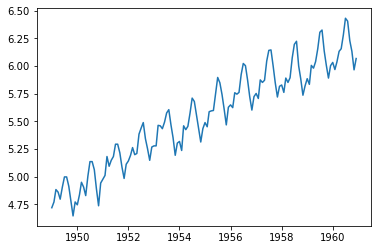

In [14]:
#1 log transformation
ts_log = np.log(ts)
plt.plot(ts_log)

It shows an upward trend anyway, so we need additional transformations.

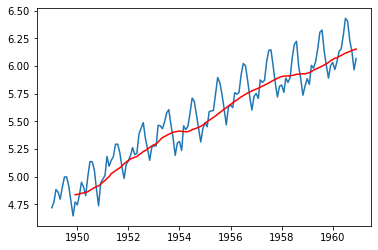

In [15]:
#2 Let's calculate the moving average of the series and substract it from the series (log transformed)
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [16]:
#moving average substraction
ts_log_movavg_diff = ts_log - moving_avg
ts_log_movavg_diff.dropna(inplace=True) #dropping the first na values

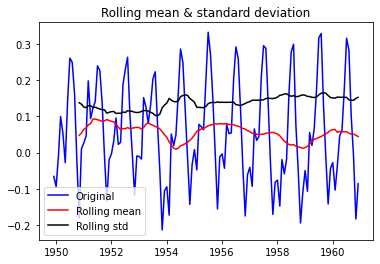

Results of Dickey Fuller Test
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [17]:
test_stationarity(ts_log_movavg_diff)

Test statistic is smaller than 5% value. Anyway, one of the dropbacks of this method is the window for the rolling mean. This could be offset with a exponentially weighted moving average, with heavier weights in most recent observations.

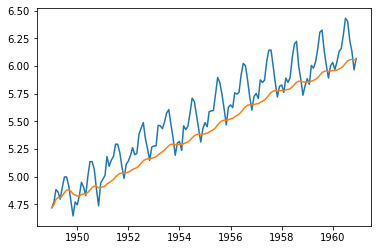

In [30]:
ts_log_ewma = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(ts_log_ewma)

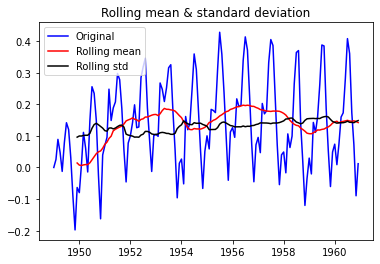

Results of Dickey Fuller Test
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [31]:
ts_log_ewma_diff = ts_log - ts_log_ewma
test_stationarity(ts_log_ewma_diff)

Now the test statistic is lower than the 